# Training BADGR algorithm 
Ji Liu

2023/7/7

In this notebook file, I aim to train the BADGR model from scratch based off the original training script (https://github.com/gkahn13/badgr). 

## 1. Reproducing the result using the original script
The original project github page (https://github.com/gkahn13/badgr) provides detailed descriptions on how to set up the conda environment and use the script to train and evaluate the model. I have followed the instructions and trained the model from scratch. 

Two datasets were provided by the original repo, i.e., collision-position and bumpy, which were used separately to train two models that were merged later to produce the full predictive model. The training log produced by running the original training script on my local machine for collision-position dataset can be found here: https://www.dropbox.com/s/hqc1f3ihyo4dynk/log_train.txt?dl=0. The training log for the bumpy dataset can be found here: https://www.dropbox.com/s/381ee36weeubzmw/log_train.txt?dl=0. A screen recording showing the planner using the trained model and producing optimal trajectories from rosbag replays can be found here: https://www.dropbox.com/s/2y85eezaikctplw/Screencast%202023-07-06%2022%3A59%3A59.mp4?dl=0

The training is performed with the following spec: </br>
OS: Ubuntu 18 </br>
Tensorflow-gpu 1.12.0 </br>
cudatoolkit 9.0 </br>
cudnn 7.3 </br>

## 2. Training using Tensorflow 2.11
### 2.1 Network structure
As the original script is based on Tensorflow 1.x, I found it necessary to reproduce the training with the updated Tensorflow 2.x version, as the old syntax is not as straightforward for modifications and troubleshooting moving forward. Thus I set up the neural network using Tensorflow 2.11 in the following cell. To create this model, several subclasses based on keras.layers.Layer class were first created to make the model more modular. These subclasses include: </br>

>* ImgNet: CNN for processing image input. The output of ImgNet is used to initiate the LSTM network. </br>
>* ActionNet: A two-layer network transforming action sequences before serving as input to the LSTM network. </br>
>* LSTMLayer: The LSTM network for producing intermediate sequence for events prediction. </br>
>* OutputLayer: The network that takes the output of LSTM as input and produce the final event prediction. </br>

These layer subclasses were contructed into the full model in the BadgrModel class.

Some modifications are made to the original network. First, some batch normalization layers are added to the ImgNet to fix gradient vanishing problem I have seen during training. Second, the activation of the final layer of OutputNet is changed from None to Sigmoid. This change is due to the fact for this training I focused on the bumpy dataset, whose output is catagorical (0 indicating not bumpy and 1 indicating otherwise). The member function cost_fn_bumpy of BadgrModel is borrowed from the original code repo with some modifications. 

In [1]:
import tensorflow as tf
from tensorflow import keras

# define network structure

class ImgNet(keras.layers.Layer):
    def __init__(self, 
                 output_dim=128):
        super(ImgNet, self).__init__()
        self.conv0 = keras.layers.Conv2D(filters=32, kernel_size=(5,5),strides=(2,2),activation='relu')
        self.bnorm0 = keras.layers.BatchNormalization()
        self.conv1 = keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),activation='relu')
        self.bnorm1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2),activation='relu')
        self.bnorm2 = keras.layers.BatchNormalization()
        self.flatten = keras.layers.Flatten()
        self.dense0 = keras.layers.Dense(256, activation='relu')
        self.dense1 = keras.layers.Dense(output_dim, activation=None)
    
    def call(self, input_tensor, training=False):
        x = self.conv0(input_tensor)
        x = self.bnorm0(x,training=training)
        x = self.conv1(x)
        x = self.bnorm1(x,training=training)
        x = self.conv2(x)
        x = self.bnorm2(x,training=training)
        x = self.flatten(x)
        x = self.dense0(x)
        x = self.dense1(x)
        return x

class ActionNet(keras.layers.Layer):
    def __init__(self, 
                 output_dim=16):
        
        super(ActionNet, self).__init__()
        self.dense0 = keras.layers.Dense(16, activation='relu')
        self.dense1 = keras.layers.Dense(output_dim, activation=None)
    
    def call(self, input_tensor, training=False):
        """
        The input are action sequence tensor of the size:
        batch_size x horizon x action_dim
        action_dim is 2 (linear and angular velocity)
        The output would be of the size:
        batch_size x horizon x output_dim
        """
        x = self.dense0(input_tensor)
        x = self.dense1(x)
        return x

class OutputNet(keras.layers.Layer):
    def __init__(self, output_dim=3):
        super(OutputNet, self).__init__()
        self.dense0 = keras.layers.Dense(32, activation='relu')
        self.dense1 = keras.layers.Dense(output_dim, activation=tf.keras.activations.sigmoid)
    
    def call(self, input_tensor, training=False):
        x = self.dense0(input_tensor)
        x = self.dense1(x)
        return x

class LSTMLayer(keras.layers.Layer):
    def __init__(self, rnn_dim=64,horizon=8,input_dim=16):
        super(LSTMLayer, self).__init__()
        self.lstm = keras.layers.LSTM(units=rnn_dim, input_shape=(horizon,input_dim),
                                     return_sequences=True)
    
    def call(self,input_tensor,initial_state=None, training=False):
        whole_seq_output = self.lstm(inputs=input_tensor,initial_state=initial_state,training=training)
        # print(whole_seq_output)
        return whole_seq_output


class BadgrModel(keras.Model):
    def __init__(self,
                horizon=8,
                rnn_dim=64,
                action_output_dim=16,
                output_dim=1,
                l2_weight=0.0001):
        
        super(BadgrModel, self).__init__()
        
        # rnn_dim*2: to split into initial state for cell and hidden state of LSTM
        self.img_net = ImgNet(output_dim=rnn_dim*2) 
        self.action_net = ActionNet(output_dim=action_output_dim)
        self.output_net = OutputNet(output_dim=output_dim)
        self.lstm_layer = LSTMLayer(rnn_dim=rnn_dim, horizon=8, input_dim=action_output_dim)
        self.l2_weight = l2_weight
        
    def call(self, img, actions, training=False):
        img_output = self.img_net(img, training=training)
        action_output = self.action_net(actions, training=training)
        
        # split (half & half) img_activation for LSTM initialization (size is batch_size x output_dim)
        init_h_state, init_c_state = tf.split(img_output, num_or_size_splits=2, axis=1)
        
        lstm_output = self.lstm_layer(action_output, initial_state=tf.compat.v1.nn.rnn_cell.LSTMStateTuple(init_c_state, init_h_state))
        
        output = self.output_net(lstm_output)
        
        return output
    
    def cost_fn_bumpy(self, model_output, outputs):
        batch_size = tf.shape(outputs.done)[0]
        batch_size_float = tf.cast(batch_size, tf.float32)

        done = tf.concat([tf.zeros([batch_size, 1], dtype=tf.bool), outputs.done[:, :-1]], axis=1)
        mask = tf.cast(tf.logical_not(done), tf.float32)
        tf.debugging.assert_positive(tf.reduce_sum(mask, axis=1))
        mask = batch_size_float * (mask / tf.reduce_sum(mask))

        ### bumpy
        # model_output_bumpy = model_outputs.bumpy[..., 0]
        model_output_bumpy = tf.squeeze(model_output,axis=2)
        bumpy = tf.cast(outputs.bumpy, tf.bool)[..., 0]
        # print(bumpy)
        # print(model_output_bumpy)
        cost_bumpy = tf.reduce_sum(
            mask * tf.nn.weighted_cross_entropy_with_logits(labels=tf.cast(bumpy, tf.float32),
                                                            logits=model_output_bumpy,
                                                            pos_weight=0.2),
            axis=1
        )

        bumpy_accuracy = tf.reduce_mean(tf.cast(tf.equal(model_output_bumpy > 0.5,
                                                         tf.cast(bumpy, tf.bool)),
                                                    tf.float32),
                                            axis=1)
        bumpy_accuracy_random = tf.reduce_mean(1. - tf.cast(bumpy, tf.float32), axis=1)

        ### regularization         
        train_var = self.trainable_variables
        cost_l2_reg = tf.add_n([ tf.nn.l2_loss(v) for v in train_var ]) * self.l2_weight * tf.ones(batch_size)

        ### filter out nans

        costs_is_finite = tf.math.is_finite(cost_bumpy)
        cost_bumpy = tf.boolean_mask(cost_bumpy, costs_is_finite)
        cost_l2_reg = tf.boolean_mask(cost_l2_reg, costs_is_finite)
        # assert cost_l2_reg.shape[0].value > 0.5 * batch_size

        ### total

        cost = cost_bumpy + cost_l2_reg

        cost = tf.math.reduce_mean(cost)
        cost_bumpy = tf.math.reduce_mean(cost_bumpy)
        bumpy_accuracy = tf.math.reduce_mean(bumpy_accuracy)
        bumpy_accuracy_random = tf.math.reduce_mean(bumpy_accuracy_random)
        cost_l2_reg = tf.math.reduce_mean(cost_l2_reg)

        return cost, cost_bumpy, bumpy_accuracy, bumpy_accuracy_random, cost_l2_reg


## 2.2 Load dataset
The dataset provided by the original repo is in the format of .tfrecords. The following cell gathers code from the repo in order to parse the files correctly. 

The following code from the repo defines several custom classes dealing with custom attribute dictionary (AttrDict), TFDatabase (Dataset, TfrecordDataset, TfrecordRebalanceDataset), and robot environment (EnvSpec, JackalEnvSpec, JackalBumpyEnvSpec). Most importantly, the correct parsing of the database depends on the variable names, shapes and types defined in the JackalEnvSpec class and JackalBumpyEnvSpec class. In addition, the Tensorflow related lines were updated to the 2.x counterparts.

In [4]:
import os
import copy
import itertools
from loguru import logger
import numpy as np

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

    def add_recursive(self, keys, value):
        """
        :param keys list(str):
        :param value (anything):
        """
        if isinstance(keys, str):
            keys = keys.split('/')

        assert len(keys) > 0

        d = self
        for key in keys[:-1]:
            if not hasattr(d, key):
                d[key] = AttrDict()
            d = d[key]

        d[keys[-1]] = value

    def get_recursive(self, keys):
        """
        :param keys list(str):
        :return: value
        """
        if isinstance(keys, str):
            keys = keys.split('/')

        d = self
        for key in keys:
            assert key in d
            d = d[key]
        return d

    def ls(self, prefix=''):
        """
        Prints all keys, and recurses into children AttrDicts
        :param prefix (str): printed before each key
        """
        for key in sorted(self.keys()):
            value = self[key]
            if isinstance(value, AttrDict):
                value.ls(prefix=prefix+key+'.')
            else:
                print(prefix + key)

    def apply_recursive(self, func):
        """
        Applies func to each value (recursively) and returns a new AttrDict
        :param func (lambda): takes in one argument and returns one object
        :return AttrDict
        """
        def _apply_recursive(func, d, d_applied):
            for key, value in d.items():
                if isinstance(value, AttrDict):
                    d_applied[key] = value_applied =  AttrDict()
                    _apply_recursive(func, value, value_applied)
                else:
                    d_applied[key] = func(value)

        d_applied = AttrDict()
        _apply_recursive(func, self, d_applied)
        return d_applied

    def modify_recursive(self, func):
        """
        Applies func to each value (recursively), modifying in-place
        :param func (lambda): takes in one argument and returns one object
        """
        for key, value in self.items():
            if isinstance(value, AttrDict):
                value.modify_recursive(func)
            else:
                self[key] = func(value)

    def assert_recursive(self, func):
        """
        Recursively asserts func on each value
        :param func (lambda): takes in one argument, outputs True/False
        """
        for key, value in self.items():
            if isinstance(value, AttrDict):
                value.assert_recursive(func)
            else:
                assert func(value)

    def filter_recursive(self, func):
        d = AttrDict()
        for key, value in self.get_leaf_items():
            if func(key, value):
                d.add_recursive(key, value)
        return d

    def get_leaf_keys(self):
        def _get_leaf_keys(d, prefix=''):
            for key, value in d.items():
                new_prefix = prefix + '/' + key if len(prefix) > 0 else key
                if isinstance(value, AttrDict):
                    yield from _get_leaf_keys(value, prefix=new_prefix)
                else:
                    yield new_prefix

        yield from _get_leaf_keys(self)

    def get_leaf_values(self):
        for key, value in self.items():
            if isinstance(value, AttrDict):
                yield from value.get_leaf_values()
            else:
                yield value

    def get_leaf_items(self):
        for key in self.get_leaf_keys():
            yield key, self.get_recursive(key)

    def __dir__(self):
        return sorted(list(set(super(AttrDict, self).__dir__())) + \
               sorted(list(set(self.keys()))))

    def copy(self):
        d = AttrDict()
        for key, value in self.get_leaf_items():
            d.add_recursive(copy.deepcopy(key), copy.deepcopy(value))
        d.__dict__ = d
        return d

    def __copy__(self):
        return self.copy()

    def __deepcopy__(self, memodict={}):
        return self.copy()

    @staticmethod
    def from_dict(d):
        d_attr = AttrDict()
        for key, value in d.items():
            d_attr.add_recursive(key.split('/'), value)
        return d_attr

    @staticmethod
    def combine(ds, func):
        leaf_keys = tuple(sorted(ds[0].get_leaf_keys()))
        for d in ds[1:]:
            assert leaf_keys == tuple(sorted(d.get_leaf_keys()))

        d_combined = AttrDict()
        for k in leaf_keys:
            values = [d.get_recursive(k) for d in ds]
            value = func(values)
            d_combined.add_recursive(k, value)

        return d_combined

def get_files_ending_with(folder_or_folders, ext):
    if isinstance(folder_or_folders, str):
        folder = folder_or_folders
        assert os.path.exists(folder)

        fnames = []
        for fname in os.listdir(folder):
            if fname.endswith(ext):
                fnames.append(os.path.join(folder, fname))
        return sorted(fnames)
    else:
        assert hasattr(folder_or_folders, '__iter__')
        return list(itertools.chain(*[get_files_ending_with(folder, ext) for folder in folder_or_folders]))

class Dataset(object):

    def __init__(self, env_spec):
        self._env_spec = env_spec


class TfrecordDataset(Dataset):

    def __init__(self, params):
        # assert not tf.executing_eagerly()
        super(TfrecordDataset, self).__init__(env_spec=params.env_spec)

        self._tfrecord_folders = params.tfrecord_folders

        self._horizon = params.horizon
        self._batch_size = params.batch_size

        self._is_shuffle_and_repeat = params.get('is_shuffle_and_repeat', True)
        self._num_parallel_calls = params.num_parallel_calls
        self._shuffle_buffer_size = params.shuffle_buffer_size
        self._prefetch_buffer_size_multiplier = params.prefetch_buffer_size_multiplier

        self._iterator = self._load_tfrecords()
        self._static_inputs_and_outputs = None

    #############
    ### Setup ###
    #############

    def _tfrecord_parse_fn(self, dataset):
        names = ['inputs/' + name for name in self._env_spec.observation_names + self._env_spec.action_names] + \
                ['outputs/' + name for name in self._env_spec.output_observation_names]

        dtypes = [
            tf.dtypes.as_dtype(self._env_spec.names_to_dtypes.get_recursive(
                name.replace('inputs/', '').replace('outputs/', '')))
            for name in names
        ]
        dtypes = [dtype if dtype != tf.bool else tf.uint8 for dtype in dtypes]

        shapes = []
        for name in names:
            name_suffix = name.replace('inputs/', '').replace('outputs/', '')
            shape = list(self._env_spec.names_to_shapes.get_recursive(name_suffix))
            if name.startswith('outputs/') or name_suffix in self._env_spec.action_names:
                shape = [self._horizon] + shape
            shapes.append(shape)

        names.append('outputs/done')
        dtypes.append(tf.uint8)
        shapes.append((self._horizon,))

        parsed = tf.io.parse_single_example(
            dataset,
            {name: tf.io.FixedLenFeature([], tf.string) for name in names}
        )
        decoded_parsed = {name: tf.io.decode_raw(parsed[name], dtype) for name, dtype in zip(names, dtypes)}

        reshaped_decoded_parsed = dict()
        for name, shape in zip(names, shapes):
            tensor = decoded_parsed[name]
            tensor.set_shape([np.prod(shape)])
            tensor = tf.reshape(tensor, shape)
            reshaped_decoded_parsed[name] = tensor

        reshaped_decoded_parsed['outputs/done'] = tf.cast(reshaped_decoded_parsed['outputs/done'], tf.bool)

        # randomize actions after done
        done_float = tf.cast(reshaped_decoded_parsed['outputs/done'], tf.float32)[:, tf.newaxis]
        for name in self._env_spec.action_names:
            lower, upper = self._env_spec.names_to_limits.get_recursive(name)
            shape = self._env_spec.names_to_shapes.get_recursive(name)
            action = reshaped_decoded_parsed['inputs/' + name]
            
            # horizon = action.shape[0].value
            horizon = action.shape[0]
            action = (1 - done_float) * action + done_float * \
                                                 tf.random.uniform(shape=[horizon] + list(shape),
                                                                   minval=lower, maxval=upper)
            reshaped_decoded_parsed['inputs/' + name] = action

        return reshaped_decoded_parsed

    def _filter_out_input_nans(self, dataset):
        return dataset.filter(
            lambda x: tf.reduce_all([tf.reduce_all(tf.math.is_finite(tensor)) for key, tensor in x.items()
                                     if key.startswith('inputs/') and tensor.dtype != tf.uint8]))

    def _load_tfrecords(self):
        # logger.debug('Loading tfrecords...')
        # for tfrecord_folder in self._tfrecord_folders:
        #     logger.debug(tfrecord_folder)
        tfrecord_fnames = get_files_ending_with(self._tfrecord_folders, '.tfrecord')
        assert len(tfrecord_fnames) > 0
        if self._is_shuffle_and_repeat:
            np.random.shuffle(tfrecord_fnames)
        else:
            tfrecord_fnames = sorted(tfrecord_fnames)

        dataset = tf.data.TFRecordDataset(tfrecord_fnames)
        dataset = dataset.map(self._tfrecord_parse_fn)
        dataset = self._filter_out_input_nans(dataset)
        if self._is_shuffle_and_repeat:
            dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=self._shuffle_buffer_size))
        dataset = dataset.batch(self._batch_size)
        dataset = dataset.prefetch(buffer_size=self._prefetch_buffer_size_multiplier * self._batch_size)

        iterator = iter(dataset)

        return iterator

    ################
    ### Get data ###
    ################

    def get_batch(self):
        # if self._static_inputs_and_outputs is None:
        #     self._static_inputs_and_outputs = self._iterator.get_next()
        # inputs_and_outputs = self._static_inputs_and_outputs
        inputs_and_outputs = self._iterator.get_next()

        inputs = AttrDict()
        outputs = AttrDict()
        for key, value in inputs_and_outputs.items():
            if key.startswith('inputs/'):
                inputs.add_recursive(key.replace('inputs/', ''), value)
            else:
                outputs.add_recursive(key.replace('outputs/', ''), value)

        return inputs, outputs

    
class TfrecordRebalanceDataset(TfrecordDataset):

    def __init__(self, params):
        self._rebalance_key = params.rebalance_key
        self._rebalance_logical_not = params.get('rebalance_logical_not', False)

        super(TfrecordRebalanceDataset, self).__init__(params)

    #############
    ### Setup ###
    #############

    def _load_tfrecords(self):
        logger.debug('Loading tfrecords...')
        for tfrecord_folder in sorted(self._tfrecord_folders):
            logger.debug(tfrecord_folder)
        tfrecord_fnames = get_files_ending_with(sorted(self._tfrecord_folders), '.tfrecord')
        assert len(tfrecord_fnames) > 0
        np.random.shuffle(tfrecord_fnames)

        dataset = tf.data.TFRecordDataset(tfrecord_fnames)
        dataset = dataset.map(self._tfrecord_parse_fn, num_parallel_calls=self._num_parallel_calls)
        dataset = self._filter_out_input_nans(dataset)

        dataset_true = dataset.filter(lambda x: tf.reduce_any(
            tf.cast(x[self._rebalance_key], tf.bool) if not self._rebalance_logical_not else
            tf.logical_not(tf.cast(x[self._rebalance_key], tf.bool))))
        dataset_false = dataset.filter(lambda x: tf.logical_not(tf.reduce_any(
            tf.cast(x[self._rebalance_key], tf.bool) if not self._rebalance_logical_not else
            tf.logical_not(tf.cast(x[self._rebalance_key], tf.bool)))))

        dataset_true = dataset_true.apply(tf.data.experimental.shuffle_and_repeat(
            buffer_size=self._shuffle_buffer_size // 2))
        dataset_false = dataset_false.apply(tf.data.experimental.shuffle_and_repeat(
            buffer_size=self._shuffle_buffer_size // 2))

        dataset = tf.data.experimental.sample_from_datasets([dataset_true, dataset_false])
        dataset = dataset.batch(self._batch_size)

        dataset = dataset.prefetch(buffer_size=self._prefetch_buffer_size_multiplier * self._batch_size)

        iterator = iter(dataset)

        return iterator

class EnvSpec(object):

    def __init__(self, names_shapes_limits_dtypes):
        names_shapes_limits_dtypes = list(names_shapes_limits_dtypes)
        names_shapes_limits_dtypes += [('done', (1,), (0, 1), bool)]

        self._names_to_shapes = AttrDict()
        self._names_to_limits = AttrDict()
        self._names_to_dtypes = AttrDict()
        for name, shape, limit, dtype in names_shapes_limits_dtypes:
            self._names_to_shapes.add_recursive(name, shape)
            self._names_to_limits.add_recursive(name, limit)
            self._names_to_dtypes.add_recursive(name, dtype)

    @property
    def observation_names(self):
        raise NotImplementedError

    @property
    def output_observation_names(self):
        return self.observation_names

    @property
    def action_names(self):
        raise NotImplementedError

    @property
    def names(self):
        return self.observation_names + self.action_names

    @property
    def names_to_shapes(self):
        return self._names_to_shapes

    @property
    def names_to_limits(self):
        return self._names_to_limits

    @property
    def names_to_dtypes(self):
        return self._names_to_dtypes

    def dims(self, names):
        return np.array([np.sum(self.names_to_shapes.get_recursive(name)) for name in names])

    def dim(self, names):
        return np.sum(self.dims(names))

    def normalize(self, inputs):
        """
        :param inputs (AttrDict):
        :return: AttrDict
        """
        inputs_normalized = AttrDict()
        for key, value in inputs.get_leaf_items():
            lower, upper = self.names_to_limits.get_recursive(key)

            lower, upper = np.array(lower), np.array(upper)
            mean = 0.5 * (lower + upper)
            std = 0.5 * (upper - lower)

            value_normalized = (value - mean) / std

            inputs_normalized.add_recursive(key, value_normalized)

        return inputs_normalized

    def denormalize(self, inputs):
        """
        :param inputs (AttrDict):
        :return: AttrDict
        """
        inputs_denormalized = AttrDict()
        for key, value in inputs.get_leaf_items():
            lower, upper = self.names_to_limits.get_recursive(key)

            lower, upper = np.array(lower), np.array(upper)
            mean = 0.5 * (lower + upper)
            std = 0.5 * (upper - lower)

            value_denormalized = value * std + mean

            inputs_denormalized.add_recursive(key, value_denormalized)

        return inputs_denormalized

    # def process_image(self, name, image):
    #     """
    #     Default behavior: resize the image
    #     """
    #     if len(image.shape) == 4:
    #         return np.array([self.process_image(name, im_i) for im_i in image])

    #     return imresize(image, self.names_to_shapes.get_recursive(name))


class JackalEnvSpec(EnvSpec):

    def __init__(self):
        super(JackalEnvSpec, self).__init__(
            names_shapes_limits_dtypes=(
                ('images/rgb_left', (96, 128, 3), (0, 255), np.uint8),
                ('images/rgb_right', (96, 128, 3), (0, 255), np.uint8),
                ('images/thermal', (32, 32), (-1, 1), np.float32), # TODO: don't know good limits
                ('lidar', (360,), (0., 12.), np.float32),
                ('collision/close', (1,), (0, 1), bool),
                ('collision/flipped', (1,), (0, 1), bool),
                ('collision/stuck', (1,), (0, 1), bool),
                ('collision/any', (1,), (0, 1), bool),
                ('gps/is_fixed', (1,), (0, 1), np.float32),
                ('gps/latlong', (2,), (0, 1), np.float32),
                ('gps/utm', (2,), (0, 1), np.float32),
                ('imu/angular_velocity', (3,), (-1.0 * np.pi, 1.0 * np.pi), np.float32),
                ('imu/compass_bearing', (1,), (-np.pi, np.pi), np.float32),
                ('imu/linear_acceleration', (3,), ((-1., -1., 9.81-1.), (1., 1., 9.81+1.)), np.float32),
                ('jackal/angular_velocity', (1,), (-1.0 * np.pi, 1.0 * np.pi), np.float32),
                ('jackal/linear_velocity', (1,), (-1., 1.), np.float32),
                ('jackal/imu/angular_velocity', (3,), (-1.0 * np.pi, 1.0 * np.pi), np.float32),
                ('jackal/imu/linear_acceleration', (3,), ((-1., -1., 9.81-1.), (1., 1., 9.81+1.)), np.float32),
                ('jackal/position', (3,), (-0.5, 0.5), np.float32),
                ('jackal/yaw', (1,), (-np.pi, np.pi), np.float32),
                ('android/illuminance', (1,), (0., 200.), np.float32),
                ('bumpy', (1,), (0, 1), bool),

                ('commands/angular_velocity', (1,), (-1.0, 1.0), np.float32),
                ('commands/linear_velocity', (1,), (0.75, 1.25), np.float32)
            )
        )

        fx, fy, cx, cy = 272.547000, 266.358000, 320.000000, 240.000000
        self._dim = (640, 480)
        self._K = np.array([[fx, 0., cx],
                      [0., fy, cy],
                      [0., 0., 1.]])
        self._D = np.array([[-0.038483, -0.010456, 0.003930, -0.001007]]).T
        self._balance = 0.5

    @property
    def observation_names(self):
        return (
            'images/rgb_left',
            'images/rgb_right',
            'images/thermal',
            'collision/close',
            'collision/flipped',
            'collision/stuck',
            'collision/any',
            'gps/is_fixed',
            'gps/latlong',
            'imu/angular_velocity',
            'imu/compass_bearing',
            'imu/linear_acceleration',
            'jackal/angular_velocity',
            'jackal/linear_velocity',
            'jackal/imu/angular_velocity',
            'jackal/imu/linear_acceleration',
            'jackal/position',
            'jackal/yaw',
            'android/illuminance',
        )

    @property
    def output_observation_names(self):
        return (name for name in self.observation_names if 'rgb' not in name)

    @property
    def action_names(self):
        return (
            'commands/angular_velocity',
            'commands/linear_velocity'
        )

class JackalBumpyEnvSpec(JackalEnvSpec):

    def __init__(self, left_image_only=False):
        self._left_image_only = left_image_only
        super(JackalBumpyEnvSpec, self).__init__()

    @property
    def observation_names(self):
        names = [
            'images/rgb_left',

            'jackal/imu/angular_velocity',
            'jackal/imu/linear_acceleration',
            'imu/angular_velocity',
            'imu/linear_acceleration',

            'bumpy',
        ]
        if not self._left_image_only:
            names.append('images/rgb_right')
        return tuple(names)
    


The following cell uses the classes defined above and reads in the dataset (bumpy) and separates them into the training set and the holdout set for evaluating the model. 

The way training and holdout set are defined is the same as in the original training script, where data from the date "09-12" was used as the holdout set while the rest were used as the training set. The output of this cell shows the dataset being loaded.

In [112]:
# set up bumpy env
bumpy_env_spec = JackalBumpyEnvSpec(left_image_only=True)

# define horizon and batch size
horizon = 8
batch_size=32

# specifiy data path and dataset date list
data_path = r'C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords'
full_date_list = ['08-02', '08-06', '08-08', '08-13', '08-15', '08-18', '08-20', '08-27', '08-29', '09-09', '09-12', '09-17',
         '09-19', '10-20', '10-24', '10-31']

# separate train and holdout folders
all_tfrecord_folders = [
        os.path.join(data_path, 'tfrecords_bumpy/{0}-2019_horizon_{1}'.format(f, horizon)) for f in
        full_date_list
        ]
train_tfrecord_folders = [fname for fname in all_tfrecord_folders if '09-12' not in fname]
holdout_tfrecord_folders = [fname for fname in all_tfrecord_folders if '09-12' in fname]

params_train = AttrDict(
        env_spec=bumpy_env_spec,
        tfrecord_folders=train_tfrecord_folders,

        rebalance_key='outputs/bumpy',
        rebalance_logical_not=True,

        horizon=horizon,
        batch_size=batch_size,

        num_parallel_calls=6,
        shuffle_buffer_size=1000,
        prefetch_buffer_size_multiplier=10,
    )

# define the training and holdout dataset
params_holdout = params_train.copy()
params_holdout.tfrecord_folders = holdout_tfrecord_folders

dataset_train = TfrecordRebalanceDataset(params_train)
dataset_holdout = TfrecordRebalanceDataset(params_holdout)

2023-07-06 19:21:59.499 | DEBUG    | __main__:_load_tfrecords:322 - Loading tfrecords...
2023-07-06 19:21:59.501 | DEBUG    | __main__:_load_tfrecords:324 - C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords\tfrecords_bumpy/08-02-2019_horizon_8
2023-07-06 19:21:59.501 | DEBUG    | __main__:_load_tfrecords:324 - C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords\tfrecords_bumpy/08-06-2019_horizon_8
2023-07-06 19:21:59.502 | DEBUG    | __main__:_load_tfrecords:324 - C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords\tfrecords_bumpy/08-08-2019_horizon_8
2023-07-06 19:21:59.503 | DEBUG    | __main__:_load_tfrecords:324 - C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords\tfrecords_bumpy/08-13-2019_horizon_8
2023-07-06 19:21:59.503 | DEBUG    | __main__:_load_tfrecords:324 - C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords\tfrecords_bumpy/08-15-2019_horizon_8
2023-07-06 19:21:59.503 | DEBUG    | __main__:_load_tfrecords:324 - C:\Users\liuji\Downloads\BADGR_bumpy_tfrecords\tfrecords_bumpy/08-18-2019_horizon_8

To validate that the dataset are read in correctly, some example images in the dataset is shown in the following cell.

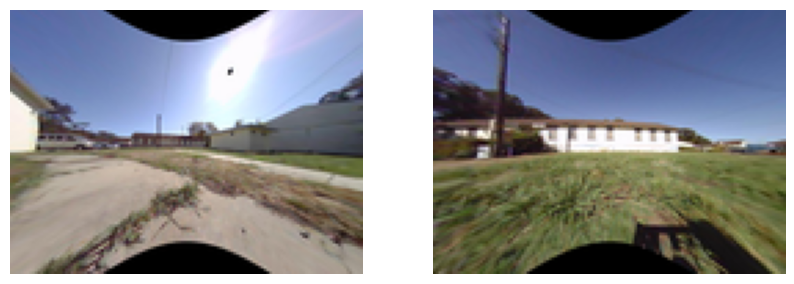

In [129]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))

# fetch one batch of data
inputs, outputs = dataset_train.get_batch()
plt.subplot(1,2,1)
plt.imshow(inputs['images']['rgb_left'][0,:,:,:].numpy())
plt.gca().axis('off')

# fetch another batch of data
inputs, outputs = dataset_train.get_batch()
plt.subplot(1,2,2)
plt.imshow(inputs['images']['rgb_left'][0,:,:,:].numpy())
plt.gca().axis('off')

plt.show()

## 2.3 Training the model

In the following cell, the training is performed on the bumpy dataset. The BADGR model is first defined and compiled with the Adam optimizer. Then the training is performed batch by batch for a total of 100000 epochs/steps (same as in the original training script). The training and holdout accuracy were saved every 100 steps to track the training progress. The initial learning rate is 1e-4, the same as specified in the original training script. It is also set up to decrease exponenially every 500 training steps (multiplied by 0.99 each time) for model convergence. The saved models are under the directory 'tmp/checkpoints6'.

In [117]:
# helper function for grabbing data batches

def get_data_bumpy(env_spec, ds):
    inputs, outputs = ds.get_batch()

    # normalize input
    inputs = env_spec.normalize(inputs)

    # get image and actions as input to the model
    img = inputs['images']['rgb_left']
    lin_cmd = inputs['commands']['linear_velocity']
    ang_cmd = inputs['commands']['angular_velocity']
    actions = tf.concat([lin_cmd, ang_cmd],axis=2)

    # bumpy is the output to be predicted (value of 0 or 1)
    bumpy = outputs['bumpy']

    return img, actions, bumpy, inputs, outputs


# define BADGR model 
lr = 1e-4
badgrmdl = BadgrModel(output_dim=1,l2_weight=0.00001)
badgrmdl.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

# set up checkpoints
checkpoint_directory = "tmp/checkpoints6"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tf.train.Checkpoint(model=badgrmdl)
status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_directory))

# specify training steps
max_step = int(1e5)
report_step = int(1e2)
save_step = 2000
lr_step = 500

# list for saving training and holdout accuracy
acc_list = []

for step in range(max_step):
    # get batch from dataset
    img, actions, bumpy, inputs, outputs = get_data_bumpy(bumpy_env_spec, dataset_train)

    # do training 
    with tf.GradientTape() as tape:
        mdl_output = badgrmdl(img, actions, training=True)
        cost, cost_bumpy, bumpy_accuracy, bumpy_accuracy_random, cost_l2_reg = badgrmdl.cost_fn_bumpy(mdl_output,outputs)

    gradient = tape.gradient(cost, badgrmdl.trainable_variables)
    badgrmdl.optimizer.apply_gradients(zip(gradient, badgrmdl.trainable_variables))

    # report training progress, calculate holdout accuracy
    if step>0 and step % report_step == 0:
        print(f'--- step {step}')
        print(f'train cost bumpy {cost_bumpy:.3}, accuracy {bumpy_accuracy:.3}, l2 cost {cost_l2_reg:.3}')
        print(tf.norm(gradient[0]))

        # perform a hold out step
        img, actions, bumpy, inputs, outputs = get_data_bumpy(bumpy_env_spec, dataset_holdout)
        mdl_output = badgrmdl(img, actions, training=True)
        cost_holdout, cost_bumpy_holdout, bumpy_accuracy_holdout, bumpy_accuracy_random_holdout, cost_l2_reg_holdout = \
            badgrmdl.cost_fn_bumpy(mdl_output,outputs)
        print(f'hold out cost bumpy {cost_bumpy_holdout:.3}, accuracy {bumpy_accuracy_holdout:.3}, l2 cost {cost_l2_reg_holdout:.3}')

        acc_list.append([bumpy_accuracy, bumpy_accuracy_holdout])

    # save checkpoints
    if step>0 and step % save_step == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # reduce learning rate as training progresses
    if step > 0 and step % lr_step == 0:
        lr = lr*0.99
        badgrmdl.optimizer.learning_rate = lr

# save accuracy data
accuracy = np.array(acc_list)
np.savetxt(checkpoint_directory+'/accuracy.txt',accuracy)


--- step 100
train cost bumpy 0.263, accuracy 0.52, l2 cost 0.00582
tf.Tensor(0.072487414, shape=(), dtype=float32)
hold out cost bumpy 0.196, accuracy 0.391, l2 cost 0.00581
--- step 200
train cost bumpy 0.187, accuracy 0.57, l2 cost 0.00581
tf.Tensor(0.19885847, shape=(), dtype=float32)
hold out cost bumpy 0.204, accuracy 0.586, l2 cost 0.00581
--- step 300
train cost bumpy 0.252, accuracy 0.516, l2 cost 0.0058
tf.Tensor(0.2348519, shape=(), dtype=float32)
hold out cost bumpy 0.201, accuracy 0.438, l2 cost 0.0058
--- step 400
train cost bumpy 0.231, accuracy 0.551, l2 cost 0.00579
tf.Tensor(0.24749315, shape=(), dtype=float32)
hold out cost bumpy 0.21, accuracy 0.551, l2 cost 0.00579
--- step 500
train cost bumpy 0.243, accuracy 0.688, l2 cost 0.00579
tf.Tensor(0.5090628, shape=(), dtype=float32)
hold out cost bumpy 0.251, accuracy 0.59, l2 cost 0.00579
--- step 600
train cost bumpy 0.275, accuracy 0.582, l2 cost 0.00578
tf.Tensor(0.4053739, shape=(), dtype=float32)
hold out cost bum

## 2.4 Training result
The batch accuracy for predicting future bumpiness (0/1) is plotted as a function of training step for both training and holdout dataset (with a moving average of 5 data points). The accuracy for both training and holdout set increased beyond 80% as training progressed, suggesting that the model has reached a moderate level of performance without overfitting. The final training accuracy is 0.850 while the final holdout accuracy is 0.842 (both numbers are from after moving average smoothing). This performance is comparable to the results gotten from using the original training script (training accuracy 0.887, holdout accuracy 0.839, from training log). This suggests that the model and training is set up correctly and working as intended.


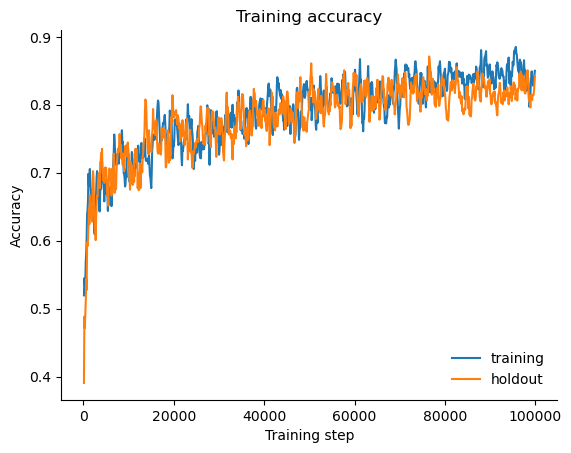

In [142]:
def mov_avg(data,win):
    ma = np.zeros(data.shape)
    s = 0.0
    for ind,num in enumerate(data):
        if ind<win:                    
            # no enough data in window, just avg over available ones
            s+=data[ind]
            ma[ind] = s/(ind+1)
        else:
            # remove the oldest data point and add the latest data point
            ma[ind] = ma[ind-1] + (data[ind]-data[ind-win])/win
    return ma

ma_train = mov_avg(accuracy[:,0],5)
ma_holdout = mov_avg(accuracy[:,1],5)
x = np.arange(1,accuracy.shape[0]+1)*report_step
plt.plot(x,ma_train)
plt.plot(x,ma_holdout)
plt.ylabel('Accuracy')
plt.xlabel('Training step')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(['training','holdout'],frameon=False,loc='lower right')
plt.title('Training accuracy')
plt.show()

# 3. Summary
In this notebook, the BADGR model is set up using Tensorflow 2.x and trained on the bumpy dataset. Some modifications were made to the network to address problems such as vanishing gradient. The final accuracy is comparable to the original training script implemented with Tensorflow 1.x. The other dataset, i.e., collision-position, can be similarly trained to produce the final combined predictive model. 

# 4. Implementation on real robot
The BADGR algorithm essentially consists of three parts: automated data gathering and labeling, predicitive model training, and planner deployment. The code presented in the original code repo and in here only addresses the training of the model, and thus more work needs to be done in the remaining parts of the algorithm for real robot implementations.

For implementation on a real robot, first a data gathering pipeline has to be designed that records sensor data such as images, IMU readings, etc. to the local disk (or upload them to the cloud directly). As the predictive model relies on the timing of the sensor data, it is important to ensure the proper synchronization of the readings across different sensors and that accurate timestamps are attached to these readings. Next, an automated data labeling pipeline needs to be designed to extract events (position, collision and bumpiness) from the sensor data. This labeling pipeline can be executed directly on the cloud whenever raw sensor data are uploaded. 

The training algorithm can then be run on the cloud with the labeled data. For lifelong learning, the training can be performed periodically using the most recently uploaded data to adapt to the new environment. Given that the cloud storage wouldn't be unlimited, old dataset would be gradually replaced by new dataset. Thus, the newly trained model would keep adapting to the changing environment, and the frequency to perform the retraining can be determined from how frequently the environment where the robot is depolyed changes.

After each predictive model retraining, the updated model is then downloaded from the cloud to the robot for policy/planner testing and deployment. The flexibility in definining the reward function for solving the optimal path provides additional ways to tune the behavior of the robot for more adaptability. Together, the entire process of data collection, labeling, training and deployment can be automated to ensure that the robot adapts dynamically to the changes of the environment. 